<a href="https://colab.research.google.com/github/rsidorchuk93/diffusers/blob/main/Playground_in_painting_with_stable_diffusion_using_%F0%9F%A7%A8diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-painting pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to do text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image

folder = '/content/drive/My Drive/photoshoot/jet'
os.listdir(folder)

['iStock-1210052747.jpg',
 'istockphoto-180842283-612x612.jpg',
 '0x0.jpg',
 'senior-businessman-suit-flying-private-260nw-1626834745.webp',
 'istockphoto-1149438579-612x612.jpg',
 '5bc891a865d332127e3bbab9.webp']

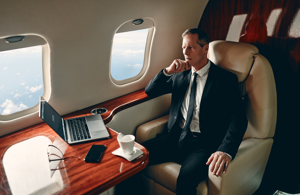

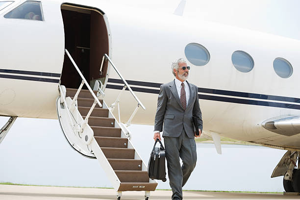

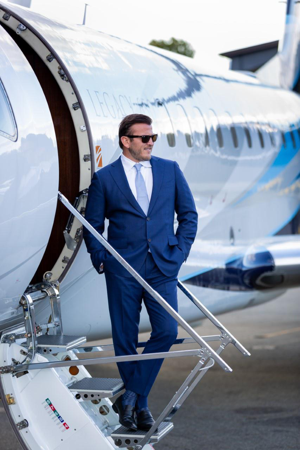

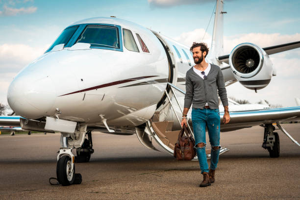

In [24]:
# Define the maximum width for the resized images
max_width = 300

# Define the spacing between images
spacing = 20

# Load the first image in the folder and get its size
file_names = os.listdir(folder)
image_path = os.path.join(folder, file_names[0])
with Image.open(image_path) as im:
    w, h = im.size
    aspect_ratio = w / h

# Iterate over all the files in the folder
for file_name in file_names:
    # Check if the file is an image (JPEG, PNG, etc.)
    if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
        # Define the path to the image file
        image_path = os.path.join(folder, file_name)
        
        # Open the image file and resize it while maintaining the original aspect ratio
        with Image.open(image_path) as im:
            w, h = im.size
            aspect_ratio = w / h
            new_width = min(w, max_width)
            new_height = int(new_width / aspect_ratio)
            im_resized = im.resize((new_width, new_height))
            
            # Display the resized image
            im_resized.show()
            
            # Add spacing between images
            Image.new('RGB', (new_width, spacing), color=(255, 255, 255)).show()

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate -q

To use private and gated models on 🤗 Hugging Face Hub, login is required. If you are only using a public checkpoint (such as `runwayml/stable-diffusion-inpainting` in this notebook), you can skip this step.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [17]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [18]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [25]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

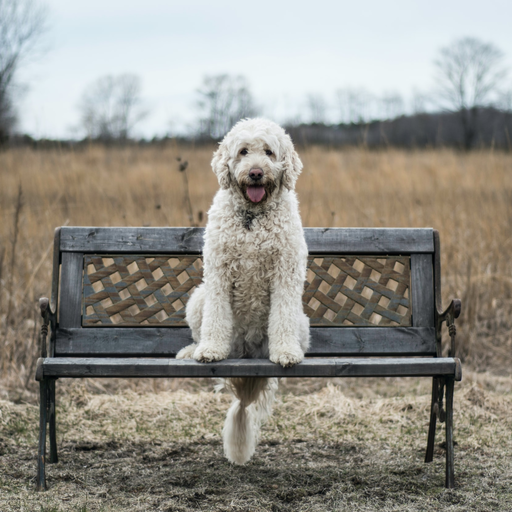

In [26]:
image = download_image(img_url).resize((512, 512))
image

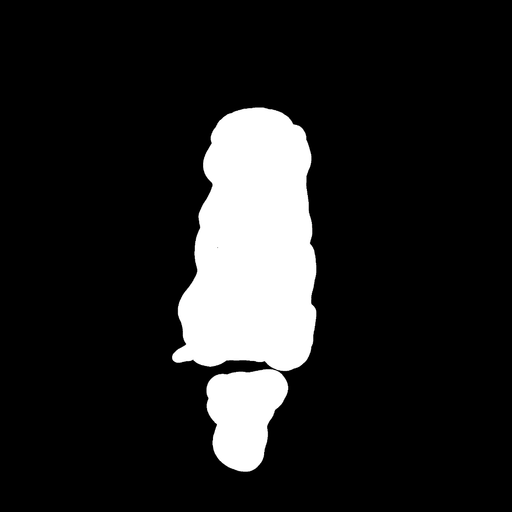

In [27]:
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [40]:
prompt = "a cat sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [41]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

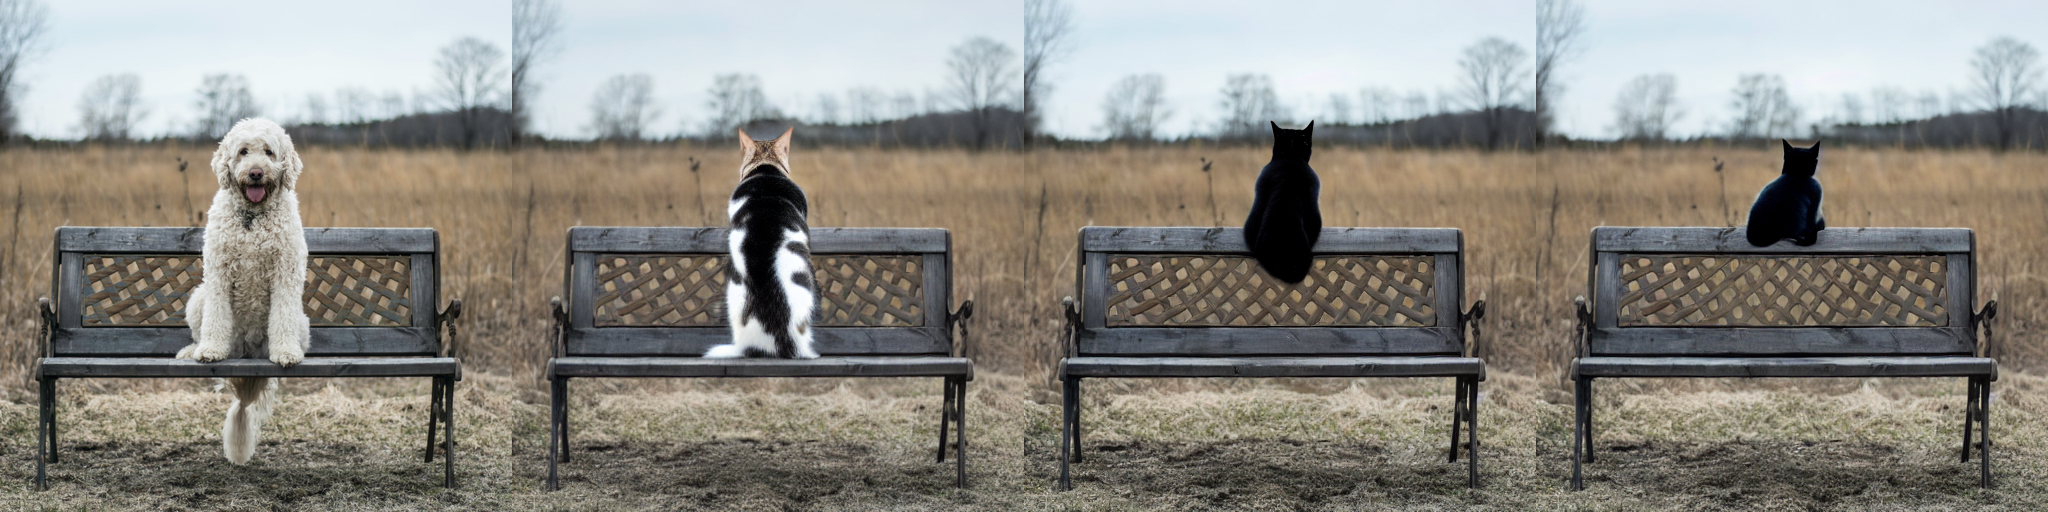

In [42]:
image_grid(images, 1, num_samples + 1)

### Gradio Demo

In [31]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

In [33]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>